# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [402]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [403]:
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


an example of a data point with label 4


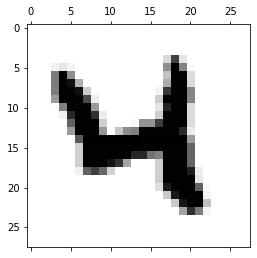

an example of a data point with label 4 before to_categorical ...
... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [404]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

print('an example of a data point with label', Y_train[20], 'before to_categorical ...')
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Example: to_categorical

In [394]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [395]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5)) #spegne i neuroni per non vincolare la rete alle informazioni di ogni singolo neurone, si attiva solo nella fase di training -> generalizzazione; nel test non ha senso, per questo il loss : test < training
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))#soft max per trasformare in probabilità
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [396]:
def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [397]:
# training parameters
batch_size = 32
epochs = 16

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/16
1875/1875 [==============================] - 9s 4ms/step - loss: 1.1197 - acc: 0.6616 - val_loss: 0.3028 - val_acc: 0.9178
Epoch 2/16
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3885 - acc: 0.8893 - val_loss: 0.2340 - val_acc: 0.9324
Epoch 3/16
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3176 - acc: 0.9102 - val_loss: 0.1969 - val_acc: 0.9421
Epoch 4/16
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2690 - acc: 0.9256 - val_loss: 0.1722 - val_acc: 0.9473
Epoch 5/16
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2320 - acc: 0.9347 - val_loss: 0.1573 - val_acc: 0.9497
Epoch 6/16
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2117 - acc: 0.9404 - val_loss: 0.1429 - val_acc: 0.9545
Epoch 7/16
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1931 - acc: 0.9463 - val_loss: 0.1303 - val_acc: 0.9580
Epoch 8/16
1875/1875 [==============================] - 8s 4ms

#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 [==============================] - 1s 2ms/step - loss: 0.0866 - acc: 0.9724

Test loss: 0.08661540597677231
Test accuracy: 0.9724000096321106


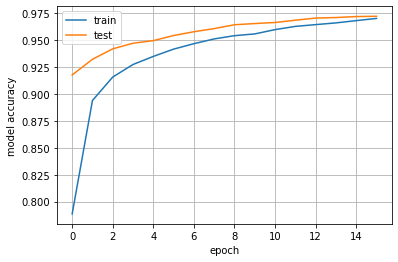

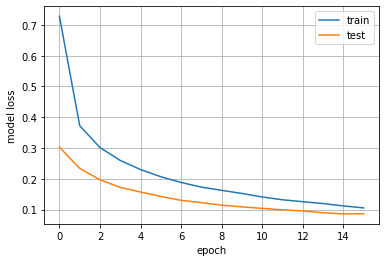

In [398]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

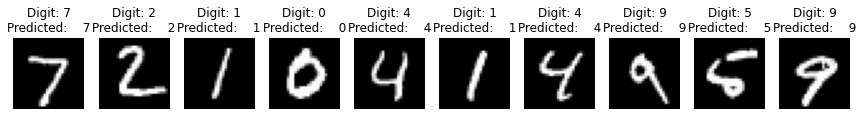

In [405]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_Test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_Test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 12.1

By keeping fixed all the other parameters, try to use at least two other optimizers, different from SGD. <span style="color:red">Watch to accuracy and loss for training and validation data and comment on the performances</span>.

In [406]:
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


In [407]:
def create_CNN():
    model = Sequential()
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
       
    return model

In [408]:
# training parameters
batch_size = 32
epochs = 16

### $i)$ Adam

In [162]:
def compile_model():
    model=create_CNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [163]:
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/16
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4855 - acc: 0.8548 - val_loss: 0.1018 - val_acc: 0.9701
Epoch 2/16
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1194 - acc: 0.9654 - val_loss: 0.0920 - val_acc: 0.9720
Epoch 3/16
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0899 - acc: 0.9736 - val_loss: 0.0755 - val_acc: 0.9769
Epoch 4/16
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0665 - acc: 0.9800 - val_loss: 0.0759 - val_acc: 0.9783
Epoch 5/16
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0496 - acc: 0.9855 - val_loss: 0.0671 - val_acc: 0.9804
Epoch 6/16
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0432 - acc: 0.9875 - val_loss: 0.0886 - val_acc: 0.9767
Epoch 7/16
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0412 - acc: 0.9874 - val_loss: 0.0807 - val_acc: 0.9799
Epoch 8/16
1875/1875 [==============================] - 9s 5m

313/313 [==============================] - 1s 2ms/step - loss: 0.0980 - acc: 0.9822

Test loss: 0.09795241057872772
Test accuracy: 0.982200026512146


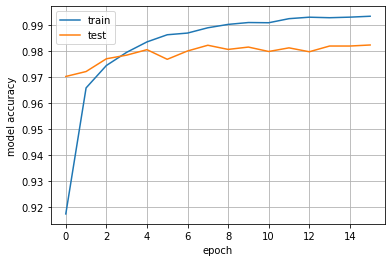

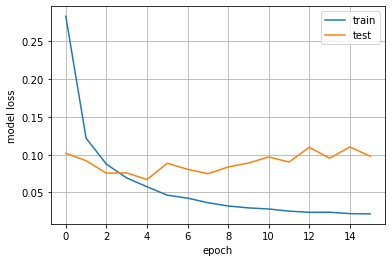

In [164]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

### $ii)$ Adamax

In [165]:
def compile_model():
    model=create_CNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adamax',
                  metrics=['acc'])
    return model

In [166]:
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/16
1875/1875 [==============================] - 11s 5ms/step - loss: 0.6357 - acc: 0.8124 - val_loss: 0.1702 - val_acc: 0.9496
Epoch 2/16
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2070 - acc: 0.9399 - val_loss: 0.1205 - val_acc: 0.9637
Epoch 3/16
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1570 - acc: 0.9552 - val_loss: 0.0956 - val_acc: 0.9709
Epoch 4/16
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1218 - acc: 0.9655 - val_loss: 0.0849 - val_acc: 0.9732
Epoch 5/16
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0939 - acc: 0.9725 - val_loss: 0.0760 - val_acc: 0.9771
Epoch 6/16
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0835 - acc: 0.9755 - val_loss: 0.0724 - val_acc: 0.9776
Epoch 7/16
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0708 - acc: 0.9802 - val_loss: 0.0689 - val_acc: 0.9784
Epoch 8/16
1875/1875 [==============================] - 9s 

313/313 [==============================] - 1s 3ms/step - loss: 0.0593 - acc: 0.9828

Test loss: 0.0592530220746994
Test accuracy: 0.9828000068664551


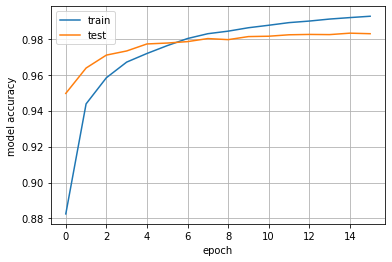

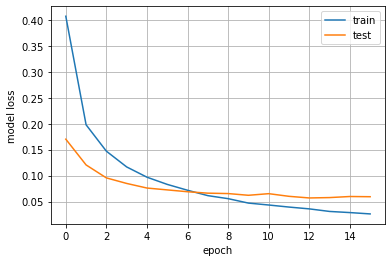

In [167]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

### $iii)$ RMSprop

In [168]:
def compile_model():
    model=create_CNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

In [169]:
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/16
1875/1875 [==============================] - 18s 9ms/step - loss: 0.4507 - acc: 0.8644 - val_loss: 0.1319 - val_acc: 0.9651
Epoch 2/16
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1417 - acc: 0.9632 - val_loss: 0.1408 - val_acc: 0.9649
Epoch 3/16
1875/1875 [==============================] - 14s 8ms/step - loss: 0.1379 - acc: 0.9685 - val_loss: 0.1382 - val_acc: 0.9698
Epoch 4/16
1875/1875 [==============================] - 14s 8ms/step - loss: 0.1363 - acc: 0.9715 - val_loss: 0.1583 - val_acc: 0.9729
Epoch 5/16
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1367 - acc: 0.9742 - val_loss: 0.1673 - val_acc: 0.9724
Epoch 6/16
1875/1875 [==============================] - 14s 8ms/step - loss: 0.1523 - acc: 0.9733 - val_loss: 0.1975 - val_acc: 0.9716
Epoch 7/16
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1500 - acc: 0.9742 - val_loss: 0.1823 - val_acc: 0.9761
Epoch 8/16
1875/1875 [==============================] -

313/313 [==============================] - 1s 2ms/step - loss: 0.3397 - acc: 0.9679

Test loss: 0.33971038460731506
Test accuracy: 0.9678999781608582


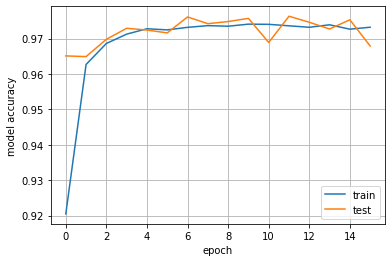

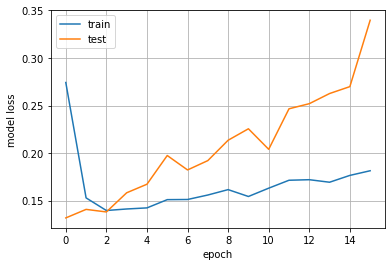

In [170]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

Let's summary the results:

#### RESULTS and COMMENTS:
optimizazion |loss | accuracy
-------------|-----|---------
$o)$ SGD   |0.0866|0.9724
$i)$ Adam   | 0.0980|0.9822
$ii)$ Adamax |0.0593|0.9828
$iii)$ RMSprop | 0.3397| 0.9679



From the graphs of the loss and the acuracy function, we can see how any of them are monotonous, while others don't show a smooth behaviour. In particular SGD optimization function remains very stable during the training test and reach an appreciable accuracy. The same can be said about the adamax optimization function, which is very stable in the testing and in the training phase, ans is also very accurate.

For the adam function we are not so happy because of the lack of stability in the testing phase. Nonetheless the reached accuracy is satisfying.
The last, the RMSprop function, has been the worst, with the highest loss function value and the smallest accuracy. Furthermore, the trende of the functions, were the worst, with an increasing loss!

So I think that the best optimization (among these 4 optimization) is given by the Adamax.

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [409]:
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)


X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [411]:
# reshape data, depending on Keras backend; in base a se vuole prima la forma o l'intensità del grigio
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows,img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows,img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

In [412]:
#prendere spunto dal moodle online
def create_DCNN():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(5, 5),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16, kernel_size=(5, 5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adamax', #usare il migliore in base al 12.1
                  metrics=['acc'])
    return model

Train your DCNN and evaluate its performance proceeding exactly as before:

In [413]:
# training parameters
batch_size = 32
epochs = 16

# create the deep conv net
model_DCNN=create_DCNN()
# train CNN
history = model_DCNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaluate model
score = model_DCNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/16
1875/1875 [==============================] - 29s 15ms/step - loss: 0.4229 - acc: 0.8781 - val_loss: 0.0775 - val_acc: 0.9740
Epoch 2/16
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0680 - acc: 0.9789 - val_loss: 0.0501 - val_acc: 0.9835
Epoch 3/16
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0486 - acc: 0.9847 - val_loss: 0.0383 - val_acc: 0.9872
Epoch 4/16
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0352 - acc: 0.9888 - val_loss: 0.0373 - val_acc: 0.9877
Epoch 5/16
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0255 - acc: 0.9922 - val_loss: 0.0314 - val_acc: 0.9896
Epoch 6/16
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0216 - acc: 0.9935 - val_loss: 0.0304 - val_acc: 0.9903
Epoch 7/16
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0174 - acc: 0.9942 - val_loss: 0.0342 - val_acc: 0.9894
Epoch 8/16
1875/1875 [==========================

313/313 [==============================] - 2s 5ms/step - loss: 0.0399 - acc: 0.9891

Test loss: 0.03991822898387909
Test accuracy: 0.9890999794006348


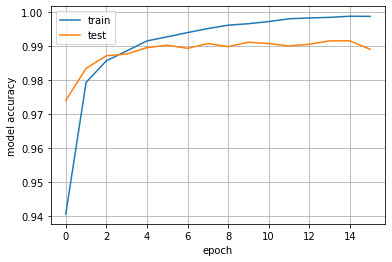

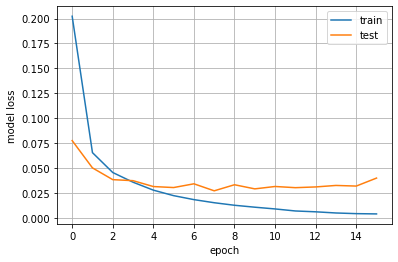

In [414]:
# evaluate model
score = model_DCNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

For this convolutional layer the accuracy is better than the DNN case, and the loss function is smaller:
 - accuracy: 0.9891
 - loss: 0.0399


In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.

X_train shape: (10000, 784)
Y_train shape: (10000, 10)

X_train shape: (10000, 28, 28, 1)
Y_train shape: (10000, 10)



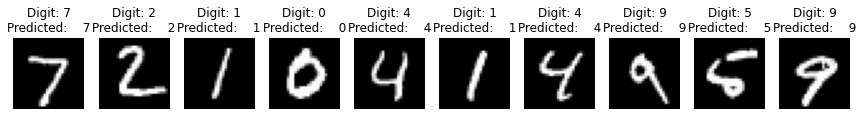

In [450]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

print('X_train shape:', X_test.shape)
print('Y_train shape:', Y_test.shape)
print()

if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows,img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows,img_cols, 1)

print('X_train shape:', X_test.shape)
print('Y_train shape:', Y_test.shape)
print()

predictions = model_DCNN.predict(X_test)
# print(np.shape(X_test))
X_Test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_Test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Also in this case the a sample of ten digits is perfectly predicted.

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

In [455]:
# TO LOAD FILES ON GOOGLE COLAB
#from google.colab import files
#upload = files.upload() #this will let you browse and choose the file to be uploaded

from PIL import Image
import os

Image size: 28x28


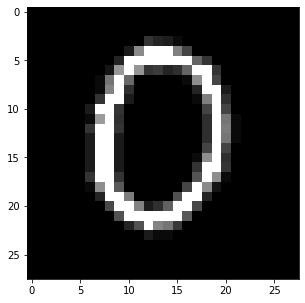

In [456]:
digit_filename = "./Pictures/0.png"
digit_in = Image.open(digit_filename).convert('L')
#digit_in = Image.open("8b.png").convert('L') #ON GOOGLE COLAB INSERT THE NAME OF THE UPLOADED FILE

ydim, xdim = digit_in.size
print("Image size: "+str(xdim)+"x"+str(ydim))
pix=digit_in.load();
data = np.zeros((xdim, ydim))
for j in range(ydim):
    for i in range(xdim):
        data[i,j]=pix[j,i]

data /= 255

plt.figure(figsize=(5,5))
plt.imshow(data, cmap='gray')
plt.show()

# print(data.shape)

I use the previously trained DNN to predict the digit:

(1, 28, 28, 1)
(1, 28, 28, 1)


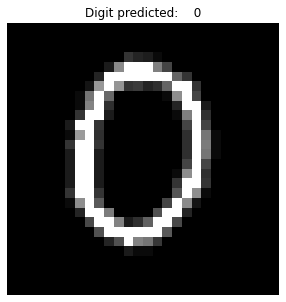

In [460]:
# print(data)
print(data.shape)
data = data.reshape(1,xdim,ydim,1)
print(data.shape)

pred_0 = model_DCNN.predict(data)
data = data.reshape(xdim,ydim)

plt.figure(figsize=(5, 5))  
plt.imshow(data, cmap='gray')    
plt.title("Digit predicted:    {}".format(np.argmax(pred_0)))
plt.axis('off') 
plt.show()

In [461]:
tutti = []
digit = []

for i in range (0,10):
    digit_filename = "./Pictures/"+str(i)+".png"
    digit.append(i)
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
#     print("Image size: "+str(xdim)+"x"+str(ydim))
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]
    data /= 255
#     plt.figure(figsize=(5,5))
#     plt.imshow(data, cmap='gray')
#     plt.show()
    tutti = np.append(tutti,data)
tutti = tutti.reshape(10, ydim,xdim,1)


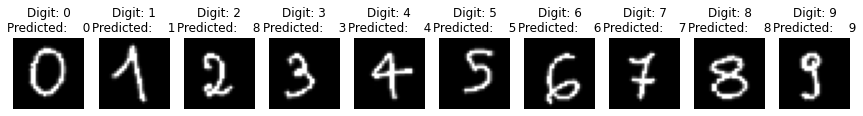

In [463]:
predictions = model_DCNN.predict(tutti)

Tutti = tutti.reshape(tutti.shape[0], ydim, xdim,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(Tutti[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(digit[i], np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Even in this case, almost all the digit are predicted!

### <span style="color:green">Supplementary information 1: Use of `gimp` </span>

- from the Unix shell type: `gimp` and hit `Return`
- File -> new (chose: 28x28 pixels)
- rascale the image to 800%
- Use the **brush** with dimension 2px to draw your digit
- Color -> invert (to have black background)
- Export the image as a `.png` file

That's all!

### <span style="color:green">Supplementary information 2: Display trained filters in your CNN</span>

Print your NN layers:

In [ ]:
layer_index=0
for layer in model_CNN.layers:
    print(layer_index, layer.name)
    layer_index+=1

Display your filters:

In [ ]:
# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()

### <span style="color:green">Supplementary information 3: Monitor layer outputs in your CNN</span>

In [ ]:
test_index = 0

from keras.models import Model
layer_outputs = [layer.output for layer in model_CNN.layers]
activation_model = Model(inputs=model_CNN.input, outputs=layer_outputs)
activations = activation_model.predict(X_test[test_index].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, layer_index): 
    activation = activations[layer_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3,col_size*3))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

In [ ]:
%matplotlib inline
plt.imshow(X_test[test_index][:,:,0], cmap='gray')
# def display_activation(activations, col_size, row_size, layer number)
display_activation(activations, 4, 2, 0)
# col_size x row_size must be <= Number of filters for the convolutional layer